# Imports

In [28]:
from pyproj import Proj, transform
from matplotlib import pyplot as plt
from shapely.geometry import Polygon
from rasterio import mask as msk
from pathlib import Path
import numpy as np
import tifffile
import rasterio
import re
import os

# Define labels and calculate ndvi maps

In [33]:
DATA_PATH = Path('C:\\Users\\danya\\Desktop\\ML\\YFR\\classification\\data')
FIRST = DATA_PATH / 'LC08_L2SP_178026_20150706_20200909_02_T1'
SECOND = DATA_PATH / 'LC08_L2SP_178026_20200703_20200913_02_T1'

FIRST_BANDS = list(filter(lambda f: re.compile('B[0-9]*.TIF').search(f), os.listdir(FIRST)))
SECOND_BANDS = list(filter(lambda f: re.compile('B[0-9]*.TIF').search(f), os.listdir(SECOND)))

# Crop coordinates
### Because landsat images have a little different coordinates it's important to scale them identically
### Coordinates were chosen manually but in fact it's just minimum of each values of each point

In [34]:
CRS = rasterio.open(FIRST / FIRST_BANDS[0]).crs

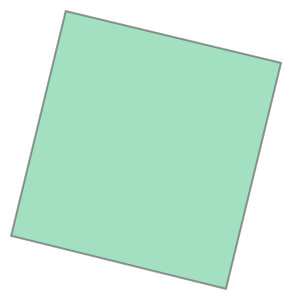

In [35]:
coordinates = np.array([
    [33.8775, 49.9280],
    [33.2271, 48.2240],
    [35.6475, 47.7907],
    [36.3802, 49.4885]
])

in_proj = Proj(init='epsg:4326')
out_proj = Proj(init=str(CRS).lower())

new_coordinates = [transform(in_proj, out_proj, coord[0], coord[1]) for coord in coordinates]
p = Polygon(new_coordinates)
Polygon(new_coordinates)

# Load first dataset

c:\Users\danya\anaconda3\envs\base-gpu\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


(<Figure size 988.8x604.8 with 1 Axes>,
 <AxesSubplot:title={'center':'ndvi1 classes'}>,
 <matplotlib.image.AxesImage at 0x266c67f9808>)

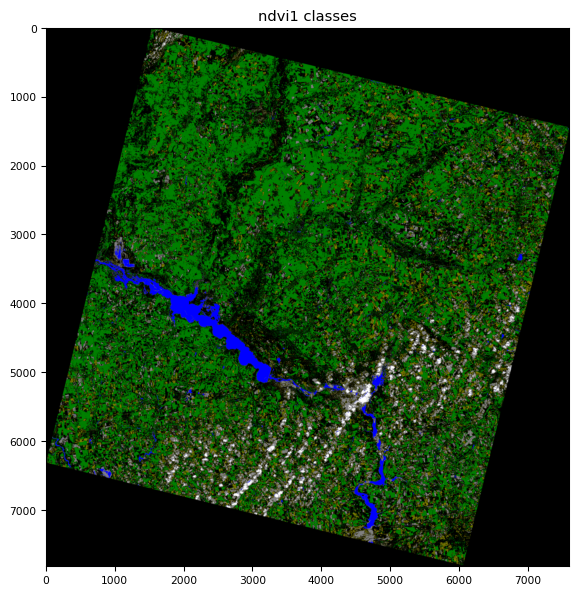

In [48]:
b1 = rasterio.open(FIRST / FIRST_BANDS[1])
r = rasterio.open(FIRST / FIRST_BANDS[3])
nir = rasterio.open(FIRST / FIRST_BANDS[4])

b1 = msk.mask(b1, [p], crop=True)[0]
r = msk.mask(r, [p], crop=True)[0]
nir = msk.mask(nir, [p], crop=True)[0]

b1 = b1[0].astype('float64')
r = r[0].astype('float64')
nir = nir[0].astype('float64')

ndvi1 = np.nan_to_num((nir - r) / (nir + r))
del nir, r

# get ndvi
ndvi1 = ndvi1.astype('float32')

# b1 (aerosol?) > 0.4 => clouds
b1 = np.where(b1 / (2 ** 16) > 0.4, 1, 0).astype('uint8')

# define output classified image
ndvi_classification1 = np.zeros(ndvi1.shape + (3,)).astype('uint8')
classes1 = np.zeros(ndvi1.shape + (1,)).astype('uint8')
ndvi_classification1[(ndvi1 < 0.02)&(ndvi1 != 0)] = [0, 0, 255] # water body
classes1[(ndvi1 < 0.02)&(ndvi1 != 0)] = 1
ndvi_classification1[b1 == 1] = [255, 255, 255] # clouds
classes1[b1 == 1] = 2
ndvi_classification1[(ndvi1 >= 0.02)&(ndvi1 < 0.12)] = [128, 128, 128] # shadow/buildings
classes1[(ndvi1 >= 0.02)&(ndvi1 < 0.12)] = 3
ndvi_classification1[(ndvi1 > 0.15)&(ndvi1 < 0.2)] = [128, 128, 0] # bair soil/sand
classes1[(ndvi1 > 0.15)&(ndvi1 < 0.2)] = 4
ndvi_classification1[(ndvi1 >= 0.2)&(ndvi1 < 0.4)] = [0, 256, 0] # low
classes1[(ndvi1 >= 0.2)&(ndvi1 < 0.4)] = 5
ndvi_classification1[(ndvi1 >= 0.4)] = [0, 128, 0] # huge
classes1[(ndvi1 >= 0.4)] = 6

ndvi_classification1 = ndvi_classification1.astype('uint8')
tifffile.imsave('../scripts/data/data/ndvi_classification1.TIF', ndvi_classification1)
tifffile.imsave('../scripts/data/data/ndvi1.TIF', ndvi1)
tifffile.imshow(ndvi_classification1.astype('uint8'), title='ndvi1 classes')

c:\Users\danya\anaconda3\envs\base-gpu\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


(<Figure size 988.8x604.8 with 1 Axes>,
 <AxesSubplot:title={'center':'ndvi2 classes'}>,
 <matplotlib.image.AxesImage at 0x266c5451dc8>)

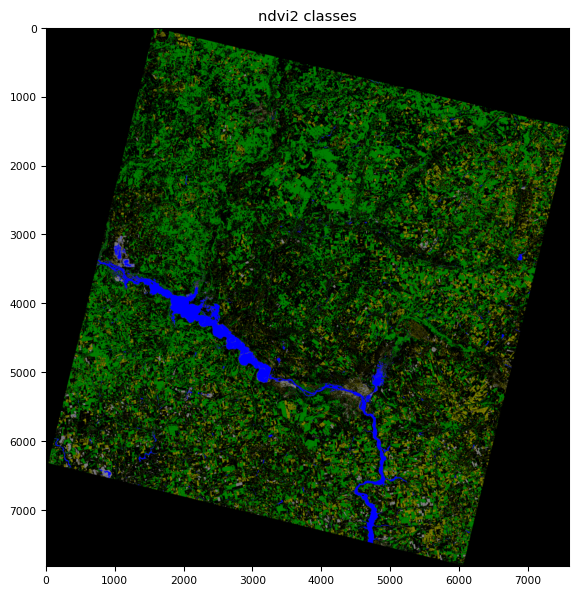

In [41]:
b1 = rasterio.open(SECOND / SECOND_BANDS[1])
r = rasterio.open(SECOND / SECOND_BANDS[3])
nir = rasterio.open(SECOND / SECOND_BANDS[4])

b1 = msk.mask(b1, [p], crop=True)[0]
r = msk.mask(r, [p], crop=True)[0]
nir = msk.mask(nir, [p], crop=True)[0]

b1 = b1[0].astype('float64')
r = r[0].astype('float64')
nir = nir[0].astype('float64')

ndvi2 = np.nan_to_num((nir - r) / (nir + r))
del nir, r

# get ndvi
ndvi2 = ndvi2.astype('float32')

# b1 (aerosol?) > 0.4 => clouds
b1 = np.where(b1 / (2 ** 16) > 0.4, 1, 0).astype('uint8')

# define output classified image
ndvi_classification2 = np.zeros(ndvi2.shape + (3,)).astype('uint8')
classes2 = np.zeros(ndvi2.shape + (1,)).astype('uint8')
ndvi_classification2[(ndvi2 < 0.02)&(ndvi2 != 0)] = [0, 0, 255] # water body
classes2[(ndvi2 < 0.02)&(ndvi2 != 0)] = 1
ndvi_classification2[b1 == 1] = [255, 255, 255] # clouds
classes2[b1 == 1] = 2
ndvi_classification2[(ndvi2 >= 0.02)&(ndvi2 < 0.12)] = [128, 128, 128] # shadow/buildings
classes2[(ndvi2 >= 0.02)&(ndvi2 < 0.12)] = 3
ndvi_classification2[(ndvi2 > 0.15)&(ndvi2 < 0.2)] = [128, 128, 0] # bair soil/sand
classes2[(ndvi2 > 0.15)&(ndvi2 < 0.2)] = 4
ndvi_classification2[(ndvi2 >= 0.2)&(ndvi2 < 0.4)] = [0, 256, 0] # low
classes2[(ndvi2 >= 0.2)&(ndvi2 < 0.4)] = 5
ndvi_classification2[(ndvi2 >= 0.4)] = [0, 128, 0] # huge
classes2[(ndvi2 >= 0.4)] = 6

ndvi_classification2 = ndvi_classification2.astype('uint8')
tifffile.imsave('../scripts/data/data/ndvi_classification2.TIF', ndvi_classification2)
tifffile.imsave('../scripts/data/data/ndvi2.TIF', ndvi2)
tifffile.imshow(ndvi_classification2.astype('uint8'), title='ndvi2 classes')

# Define classes

no data (0)<br>
deforestation (1)<br>
forestation (2)<br>
no change (3) <br>
water (4)

# NDVI Change

-0.7136226 0.66829073


(<Figure size 988.8x604.8 with 2 Axes>,
 <AxesSubplot:title={'center':'ndvi change'}>,
 <matplotlib.image.AxesImage at 0x266c695bb88>)

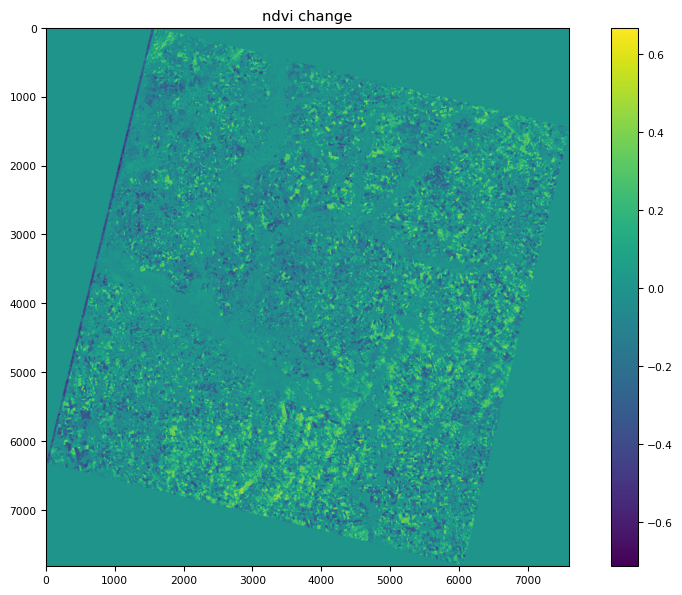

In [59]:
ndvi_diff = (ndvi2 - ndvi1)
print(ndvi_diff.min(), ndvi_diff.max())
tifffile.imshow(ndvi_diff, title='ndvi change')

# Define colors and create deforestation map

In [73]:
classes = np.zeros(classes1.shape + (1,))

# de- ,-forestation
# forest change
classes[(classes1 == 6)&(classes2 == 5)] = 1
classes[(classes1 == 5)&(classes2 == 4)] = 1
classes[(classes1 == 4)&(classes2 == 5)] = 1
classes[(classes1 == 5)&(classes2 == 6)] = 1
classes[(classes1 == 5)&(classes1 == 5)] = 1
classes[(classes1 == 6)&(classes1 == 6)] = 1

# water
classes[(classes1 == 1)|(classes2 == 1)] = 4

# no data
classes[(classes1 == 0)|(classes2 == 0)] = 0
classes[(classes1 == 2)|(classes2 == 2)] = 0
classes[(classes1 == 3)|(classes2 == 3)] = 0

deforestation_map = np.zeros(ndvi_classification1.shape)
classes.shape = (ndvi_diff.shape[0], ndvi_diff.shape[1],)  # remove last axis
eps = 0.05

deforestation_map[(classes == 1)&(ndvi_diff > eps)] = [0, 255, 0]  # forestation
classes[(classes == 1)&(ndvi_diff > eps)] = 2

deforestation_map[(classes == 1)&(ndvi_diff < -eps)] = [255, 0, 0]  # deforestation
classes[(classes == 1)&(ndvi_diff < -eps)] = 1

deforestation_map[(classes == 1)&(ndvi_diff >= -eps)&(ndvi_diff <= eps)] = [255, 255, 0]  # no change
classes[(classes == 1)&(ndvi_diff >= -eps)&(ndvi_diff <= eps)] = 3

deforestation_map[(classes == 4)] = [0, 0, 255]
deforestation_map[(classes == 0)] = [0, 0, 0]

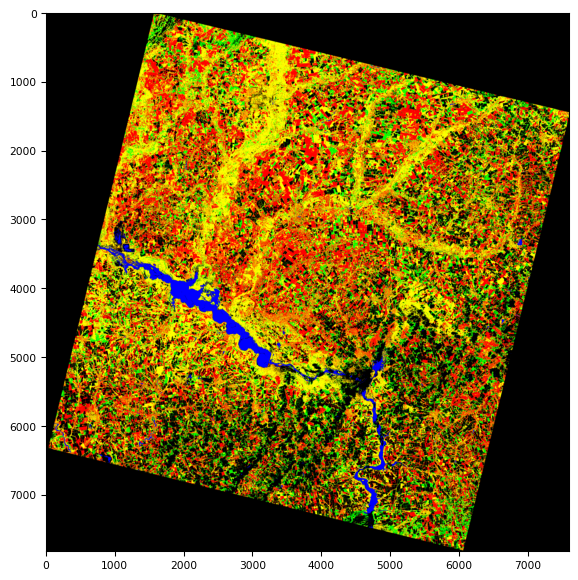

In [74]:
tifffile.imshow(deforestation_map)
tifffile.imsave('../scripts/data/data/dmap.TIF', deforestation_map.astype('uint8'))

# Save data

In [75]:
classes = classes.astype('uint8')
print(classes.shape, classes.min(), classes.max())

(7819, 7598) 0 4


In [76]:
deforestation_map = deforestation_map.astype('uint8')
print(deforestation_map.shape, deforestation_map.min(), deforestation_map.max())

(7819, 7598, 3) 0 255


In [78]:
tifffile.imsave('../scripts/data/data/classes.TIF', classes)